# Moffat fit of 20 brightest non-saturated stars in stacked image, 2017-05-17

In [156]:
import numpy as np
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model
import scipy.ndimage
%matplotlib inline

@custom_model
def Elliptical_Moffat2D(x, y, \
                        N_sky = 1., amplitude = 1., phi=0., power = 1.,\
                        x_0 = 0., y_0 = 0., width_x = 1., width_y = 1.):
    c = np.cos(phi)
    s = np.sin(phi)
    A = (c / width_x) ** 2 + (s / width_y)**2
    B = (s / width_x) ** 2 + (c/ width_y)**2
    C = 2 * s * c * (1/width_x**2 - 1/width_y**2)
    denom = (1 + A * (x-x_0)**2 + B * (y-y_0)**2 + C*(x-x_0)*(y-y_0))**power
    return N_sky + amplitude / denom 

def moffat(starlist, image_file):
    # Read in stacked image and corresponding starlist
    image = fits.getdata(image_file, header=False)
    stars = Table.read(starlist, format='ascii')
    cut_size = 40

    # Look for saturated stars (above 20,000 adu peak) and remove them
    peaks = np.array(stars['peak'])
    fluxes = np.array(stars['flux'])
    idx_sat = np.where(peaks<20000) #-----------------------mess with this parameter
    x_cents_sat = np.array(stars['xcentroid'][idx_sat])
    y_cents_sat = np.array(stars['ycentroid'][idx_sat])
    flux_sat    = np.array(stars['flux'][idx_sat])

    # Cutoff stars below some flux threshold
    flux_cut = 5 #--------------------------------------------mess with this parameter too
    idx_flux = np.where(flux_sat>=flux_cut)
    x_cents_flux = x_cents_sat[idx_flux]
    y_cents_flux = y_cents_sat[idx_flux]
    
    idx_x_cut = np.where((cut_size/2<x_cents_flux) & (x_cents_flux<(np.shape(image)[1]-cut_size/2)))

    x_cents_cut = x_cents_flux[idx_x_cut]
    y_cents_cut = y_cents_flux[idx_x_cut]
    
    idx_y_cut = np.where((cut_size/2<y_cents_cut) & (y_cents_cut<np.shape(image)[0]-cut_size/2))
    x_cents = x_cents_cut[idx_y_cut]
    y_cents = y_cents_cut[idx_y_cut]
    #Make cutout image of each star, fit star, and save data
    data = []
    data = np.zeros((len(x_cents),4))
    for i in range(len(x_cents)):

        x_cent = x_cents[i]; y_cent = y_cents[i]
        image_cut = image[y_cent-cut_size*0.5:y_cent+cut_size*0.5, x_cent-cut_size*0.5:x_cent+cut_size*0.5]
        y, x = np.mgrid[:cut_size, :cut_size]
        z = image_cut
        m_init = Elliptical_Moffat2D(N_sky = 0, amplitude=np.amax(z),  x_0=cut_size/2, y_0=cut_size/2, width_x = 4.55, width_y=4.17)
        fit_m = fitting.LevMarLSQFitter()
        m = fit_m(m_init, x, y, z)
        wid1 = 2*m.width_x.value*np.sqrt((2**(1/m.power.value))-1) * ((806/500)**0.2) * 2 * 0.04
        wid2 = 2*m.width_y.value*np.sqrt((2**(1/m.power.value))-1) * ((806/500)**0.2) * 2 * 0.04
        if wid1 < wid2:
            data[i,0] = wid1; data[i,1] = wid2
        else:
            data[i,0] = wid2; data[i,1] = wid1
        data[i,2] = m.phi.value

        #calculate empirical fwhm for same star (same algorithm as reduce_fli)
        over_samp_5 = scipy.ndimage.zoom(image_cut, 5, order = 1)
        max_flux = np.amax(over_samp_5) 
        half_max = max_flux / 2.0
        idx = np.where(over_samp_5 >= half_max)
        area_count = len(idx[0]) / 5**2
        emp_FWHM =( 2.0 * (area_count / np.pi)**0.5) * ((806/500)**0.2) * 2 * 0.04 #calibration for wv and binning and platescae
        data[i,3] = emp_FWHM
               
    return data

# Fitting all old data and appending info to stats tables

In [160]:
nights = [['20170517','FLD2', 'red', 'closed'],['20170518','FLD2_2', 'orange', 'closed'],['20170519','FLD2_2', 'green', 'closedA'],['20170520','FLD2_2', 'blue', 'closedA'],['20170521','FLD2', 'purple', 'closedA']]
d20170517c = moffat("/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[0][0]+"/FLI/reduce/stacks/"+nights[0][1]+"_stack_"+nights[0][3]+"_stars.txt", "/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[0][0]+"/FLI/reduce/stacks/"+nights[0][1]+"_stack_"+nights[0][3]+".fits")
d20170518c = moffat("/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[1][0]+"/FLI/reduce/stacks/"+nights[1][1]+"_stack_"+nights[1][3]+"_stars.txt", "/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[1][0]+"/FLI/reduce/stacks/"+nights[1][1]+"_stack_"+nights[1][3]+".fits")
d20170519c = moffat("/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[2][0]+"/FLI/reduce/stacks/"+nights[2][1]+"_stack_"+nights[2][3]+"_stars.txt", "/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[2][0]+"/FLI/reduce/stacks/"+nights[2][1]+"_stack_"+nights[2][3]+".fits")
d20170520c = moffat("/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[3][0]+"/FLI/reduce/stacks/"+nights[3][1]+"_stack_"+nights[3][3]+"_stars.txt", "/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[3][0]+"/FLI/reduce/stacks/"+nights[3][1]+"_stack_"+nights[3][3]+".fits")
d20170521c = moffat("/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[4][0]+"/FLI/reduce/stacks/"+nights[4][1]+"_stack_"+nights[4][3]+"_stars.txt", "/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[4][0]+"/FLI/reduce/stacks/"+nights[4][1]+"_stack_"+nights[4][3]+".fits")

nights = [['20170517','FLD2', 'red', 'open'],['20170518','FLD2_2', 'orange', 'open'],['20170519','FLD2_2', 'green', 'open'],['20170520','FLD2_2', 'blue', 'open'],['20170521','FLD2', 'purple', 'open']]
d20170517o = moffat("/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[0][0]+"/FLI/reduce/stacks/"+nights[0][1]+"_stack_"+nights[0][3]+"_stars.txt", "/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[0][0]+"/FLI/reduce/stacks/"+nights[0][1]+"_stack_"+nights[0][3]+".fits")
d20170518o = moffat("/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[1][0]+"/FLI/reduce/stacks/"+nights[1][1]+"_stack_"+nights[1][3]+"_stars.txt", "/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[1][0]+"/FLI/reduce/stacks/"+nights[1][1]+"_stack_"+nights[1][3]+".fits")
d20170519o = moffat("/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[2][0]+"/FLI/reduce/stacks/"+nights[2][1]+"_stack_"+nights[2][3]+"_stars.txt", "/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[2][0]+"/FLI/reduce/stacks/"+nights[2][1]+"_stack_"+nights[2][3]+".fits")
d20170520o = moffat("/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[3][0]+"/FLI/reduce/stacks/"+nights[3][1]+"_stack_"+nights[3][3]+"_stars.txt", "/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[3][0]+"/FLI/reduce/stacks/"+nights[3][1]+"_stack_"+nights[3][3]+".fits")
d20170521o = moffat("/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[4][0]+"/FLI/reduce/stacks/"+nights[4][1]+"_stack_"+nights[4][3]+"_stars.txt", "/Users/fatimaabdurrahman/Desktop/Research/RUN5/"+nights[4][0]+"/FLI/reduce/stacks/"+nights[4][1]+"_stack_"+nights[4][3]+".fits")


/Users/fatimaabdurrahman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:54: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/fatimaabdurrahman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in sqrt
/Users/fatimaabdurrahman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in sqrt


/Users/fatimaabdurrahman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater
/Users/fatimaabdurrahman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/Users/fatimaabdurrahman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater
/Users/fatimaabdurrahman/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in greater


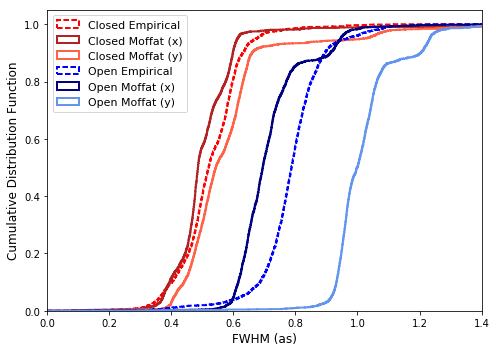

In [222]:
all_closed_mof = np.concatenate([d20170517c[:,0],d20170518c[:,0],d20170519c[:,0],d20170520c[:,0],d20170521c[:,0]])
all_open_mof   = np.concatenate([d20170517o[:,0],d20170518o[:,0],d20170519o[:,0],d20170520o[:,0],d20170521o[:,0]])
all_closed_emp = np.concatenate([d20170517c[:,3],d20170518c[:,3],d20170519c[:,3],d20170520c[:,3],d20170521c[:,3]])
all_open_emp   = np.concatenate([d20170517o[:,3],d20170518o[:,3],d20170519o[:,3],d20170520o[:,3],d20170521o[:,3]])
all_closed_mof_maj = np.concatenate([d20170517c[:,1],d20170518c[:,1],d20170519c[:,1],d20170520c[:,1],d20170521c[:,1]])
all_open_mof_maj   = np.concatenate([d20170517o[:,1],d20170518o[:,1],d20170519o[:,1],d20170520o[:,1],d20170521o[:,1]])

histbin=np.arange(0,1.5,0.001)

plt.figure(1, figsize=(7,5))

plt.hist(all_closed_emp[np.where(all_closed_emp>0)], bins=histbin, color='Red',  linestyle='dashed',normed=1, cumulative=True, histtype='step', linewidth=2, label='Closed Empirical');
plt.hist(all_closed_mof[np.where(all_closed_mof>0)], bins=histbin, color='Firebrick', normed=1, cumulative=True, histtype='step', linewidth=2, label='Closed Moffat (x)');
plt.hist(all_closed_mof_maj[np.where(all_closed_mof_maj>0)], bins=histbin, color='Tomato',  normed=1, cumulative=True, histtype='step', linewidth=2, label='Closed Moffat (y)');

plt.hist(all_open_emp[np.where(all_open_emp>0)], bins=histbin, color='Blue', linestyle='dashed', normed=1, cumulative=True, histtype='step', linewidth=2, label='Open Empirical');
plt.hist(all_open_mof[np.where(all_open_mof>0)], bins=histbin, color='Navy', normed=1, cumulative=True, histtype='step', linewidth=2, label='Open Moffat (x)');
plt.hist(all_open_mof_maj[np.where(all_open_mof_maj>0)], bins=histbin, color='cornflowerblue', normed=1, cumulative=True, histtype='step', linewidth=2, label='Open Moffat (y)');
plt.his(np.mean([all_open_mof_maj, all_open_mof])np.where

plt.legend(loc=2, fontsize=11); plt.xlim(0,1.4); plt.xlabel('FWHM (as)', fontsize=12); plt.ylabel('Cumulative Distribution Function', fontsize=12);
plt.tight_layout()
plt.savefig('mofCDF.png')